In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import resnet18, ResNet18_Weights
from pytorch_grad_cam import GradCAM
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd



In [14]:

# 📌 Définir le device (GPU ou CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 📌 Charger ResNet18 pré-entraîné avec ImageNet
weights = ResNet18_Weights.IMAGENET1K_V1
model = resnet18(weights=weights)

# 📌 Modifier la première couche pour accepter 3 canaux (FC_correlation, SC_gFA, SC_density)
model.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)

# 📌 Modifier la dernière couche pour la classification binaire
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 64),  # Réduction à 64 neurones
    nn.ReLU(),
    nn.BatchNorm1d(64),
    nn.Dropout(0.5),
    nn.Linear(64, 2)  # Classification binaire (CTRL vs SCHZ)
)

# 📌 Charger les poids entraînés
best_model_path = "Model/best_resnet18_model.pth"
model.load_state_dict(torch.load(best_model_path, map_location=device, weights_only=False))
model.to(device)
model.eval()

print("✅ Modèle ResNet18 chargé avec les poids entraînés et prêt pour Grad-CAM.")



✅ Modèle ResNet18 chargé avec les poids entraînés et prêt pour Grad-CAM.


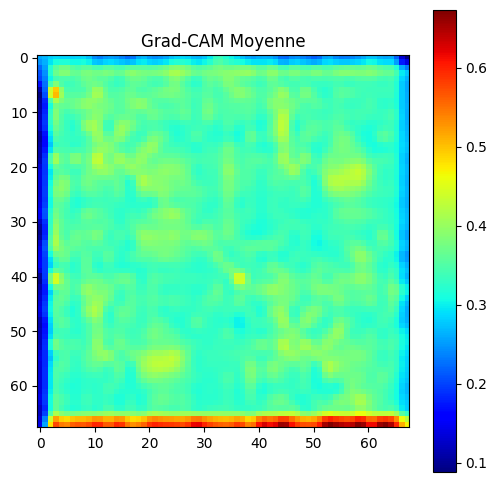

In [15]:
# 📌 Initialiser Grad-CAM
target_layer = model.conv1  # Couche de base
cam = GradCAM(model=model, target_layers=[target_layer])

# 📌 Charger le fichier H5 contenant les connectomes
h5_file = 'Data_ML/SC_FC_dataset_filtered_68x68.h5'  # Vérifie le chemin exact
keys = ['FC_correlation', 'SC_gFA', 'SC_density']

# 📌 Initialiser la carte d'importance globale
with h5py.File(h5_file, 'r') as f:
    num_patients = f[keys[0]]['schz'].shape[0]  # Nombre de patients dans chaque groupe
    total_grad_cam = np.zeros((68, 68))

    for group in ['schz', 'ctrl']:  # Boucle sur SCHZ et CTRL
        for patient_idx in range(num_patients):  # Boucle sur tous les patients
            # Charger les matrices du patient
            matrices_patient = np.stack([f[key][group][patient_idx] for key in keys], axis=0)  # (3, 68, 68)

            # Normalisation
            matrices_patient = (matrices_patient - matrices_patient.min()) / (matrices_patient.max() - matrices_patient.min() + 1e-8)

            # Calculer Grad-CAM moyen pour ce patient
            grad_cam_patient = np.zeros((68, 68))
            for i in range(3):  # Parcourir les 3 matrices (canaux)
                input_tensor = torch.zeros((1, 3, 68, 68), dtype=torch.float32).to(device)
                input_tensor[0, i] = torch.tensor(matrices_patient[i], dtype=torch.float32).to(device)

                grayscale_cam = cam(input_tensor=input_tensor)[0]
                grad_cam_patient += grayscale_cam  # Additionner les cartes des 3 canaux

            grad_cam_patient /= 3  # Moyenne des 3 canaux

            # Ajouter au total
            total_grad_cam += grad_cam_patient

# 📌 Moyenne sur tous les patients
total_grad_cam /= (num_patients * 2)  # Division par le nombre total de patients (CTRL + SCHZ)

# 📌 Afficher la carte de chaleur finale
plt.figure(figsize=(6,6))
plt.imshow(total_grad_cam, cmap='jet')
plt.colorbar()
plt.title("Grad-CAM Moyenne")
plt.show()


In [17]:
import pandas as pd
import numpy as np

# 📌 Charger le fichier CSV avec les bonnes colonnes
csv_path = "Data_ML/regions_corticales_68_indices.csv"  # Assure-toi du bon chemin
regions_df = pd.read_csv(csv_path)

# 📌 Renommer les colonnes pour plus de clarté
regions_df.rename(columns={"Indice": "index", "Région Cérébrale": "region"}, inplace=True)

# 📌 Convertir l'indice en entier et ajuster pour index 0-based
regions_df["index"] = regions_df["index"].astype(int) - 1

# 📌 Charger la carte Grad-CAM moyenne (assumée déjà définie en `total_grad_cam`)
grad_cam_array = total_grad_cam  # Assure-toi que cette variable est bien définie

# 📌 Calculer la moyenne de Grad-CAM pour chaque ligne (somme des valeurs de la ligne normalisée)
grad_cam_mean_per_region = grad_cam_array.mean(axis=1)

# 📌 Trouver les 10 régions avec la plus haute activation moyenne
num_top_regions = 10
top_10_regions_indices = np.argsort(grad_cam_mean_per_region)[-num_top_regions:][::-1]  # Trier et garder les 10 plus hautes valeurs

# 📌 Associer ces indices aux noms des régions corticales
top_10_regions = [regions_df.loc[i, "region"] for i in top_10_regions_indices]

# 📌 Afficher les 10 régions les plus influentes
print("🔍 Top 10 régions cérébrales les plus influentes selon Grad-CAM :")
for region in top_10_regions:
    print(region)





🔍 Top 10 régions cérébrales les plus influentes selon Grad-CAM :
lh_insula
lh_transversetemporal
lh_superiortemporal
rh_medialorbitofrontal
rh_precuneus
rh_cuneus
rh_pericalcarine
rh_lateraloccipital
lh_cuneus
lh_pericalcarine
